In [300]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [140]:
import sys
sys.path.insert(0, '../src')

In [500]:
import gc
import os
import warnings


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from prepare import prepare_data
from eda import (
    plot_heatmap,
    plot_pairwise_dependency,
    plot_normalised_barplot,
    plot_countplot,
    make_stylish_df
)


sns.set_style('whitegrid')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)
%matplotlib inline

In [152]:
pd.set_option(
    'display.max_rows', 100,
    'display.max_columns', None,
    'display.max_colwidth', 200,
    'display.width', 250,
    'display.float_format', '{:4,.2f}'.format
)

## Data Preparation

In [492]:
df = pd.read_csv('../data/loan.csv', low_memory=False)

In [493]:
df['loan_status'].value_counts()

Current                                                601779
Fully Paid                                             207723
Charged Off                                             45248
Late (31-120 days)                                      11591
Issued                                                   8460
In Grace Period                                          6253
Late (16-30 days)                                        2357
Does not meet the credit policy. Status:Fully Paid       1988
Default                                                  1219
Does not meet the credit policy. Status:Charged Off       761
Name: loan_status, dtype: int64

The target feature for this dataset is an indicator if the loan is good (1) or bad (0). To identify good loans, I use their loan statuses and print their counts below. The description for each status is provided by the Lending Club:

* Current: Loan is up to date on all outstanding payments.
* In Grace Period: Loan is past due but within the 15-day grace period.
* Late (16-30): Loan has not been current for 16 to 30 days.
* Late (31-120): Loan has not been current for 31 to 120 days.
* Fully paid: Loan has been fully repaid, either at the expiration of the 3- or 5-year year term or as a result of a prepayment.
* Default: Loan has not been current for an extended period of time.
* Charged Off: Loan for which there is no longer a reasonable expectation of further payments.

Since we are interested only in finished loans will select only finished ones.

In [577]:
df = prepare_data('../data/loan.csv', '../data/final_data.csv', force=True)

In [578]:
assert df.isnull().sum().max() == 0

## EDA

In [579]:
plots_dir = '../data/plots'
os.makedirs(plots_dir, exist_ok=True)

In [580]:
print(f"{df['is_default'].sum() / df.shape[0] * 100 :.2f}% form all loans are Defaulted.")

18.28% form all loans are Defaulted.


In [581]:
make_stylish_df(
    df.pivot_table(
        index=['is_default'], 
        values=['delinq_2yrs', 'annual_inc', 'dti', 'open_acc',  'inq_last_6mths', 'revol_util']
    ),
    axis=0, fmt="{:,.2f}")

,annual_inc,delinq_2yrs,dti,inq_last_6mths,open_acc,revol_util
is_default,,,,,,
False,"74,161.75",0.24,16.14,0.82,10.92,53.19
True,"65,128.92",0.28,18.44,0.98,11.06,59.44


In [582]:
temp = df.pivot_table(index=['is_default'], values=['funded_amnt', 'total_pymnt'], aggfunc='sum')
temp.loc['total'] = [temp['funded_amnt'].sum(), temp['total_pymnt'].sum()]
temp['ROI %'] = (temp['total_pymnt'] / temp['funded_amnt'] - 1) * 100

make_stylish_df(temp, axis=0, fmt="{:,.2f}")

,funded_amnt,total_pymnt,ROI %
is_default,,,
False,"2,764,140,500.00","3,154,622,890.25",14.13
True,"675,103,675.00","295,462,823.55",-56.23
total,"3,439,244,175.00","3,450,085,713.81",0.32


In [583]:
categorical_columns = ['emp_length', 'purpose', 'addr_state', 'term', 'home_ownership']
target_column = ['is_default']
numerical_columns = list(
    set(df.columns) - set(categorical_columns) - set(target_column) - {'total_pymnt', 'funded_amnt'}
)

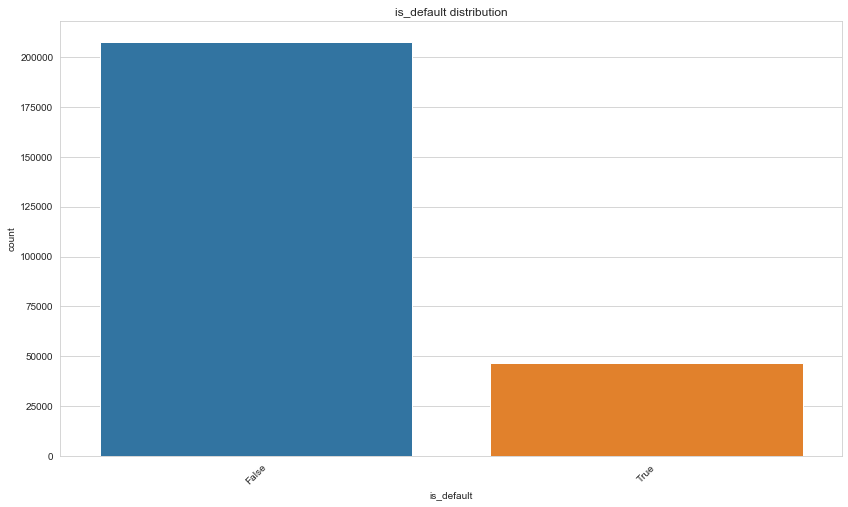

In [584]:
title = 'is_default distribution'
plot_countplot(
    df, 
    'is_default',
    title=title,
    output_path=os.path.join(plots_dir, '_'.join(title.split()))
)

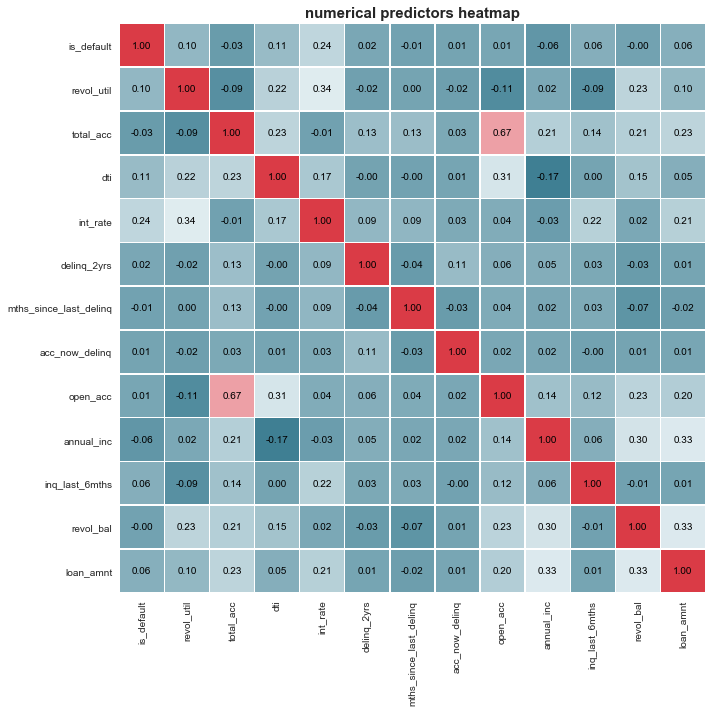

In [585]:
title = 'numerical predictors heatmap'
plot_heatmap(
    df,
    columns=target_column + numerical_columns,
    title=title,
    output_path=os.path.join(plots_dir, '_'.join(title.split()))
)

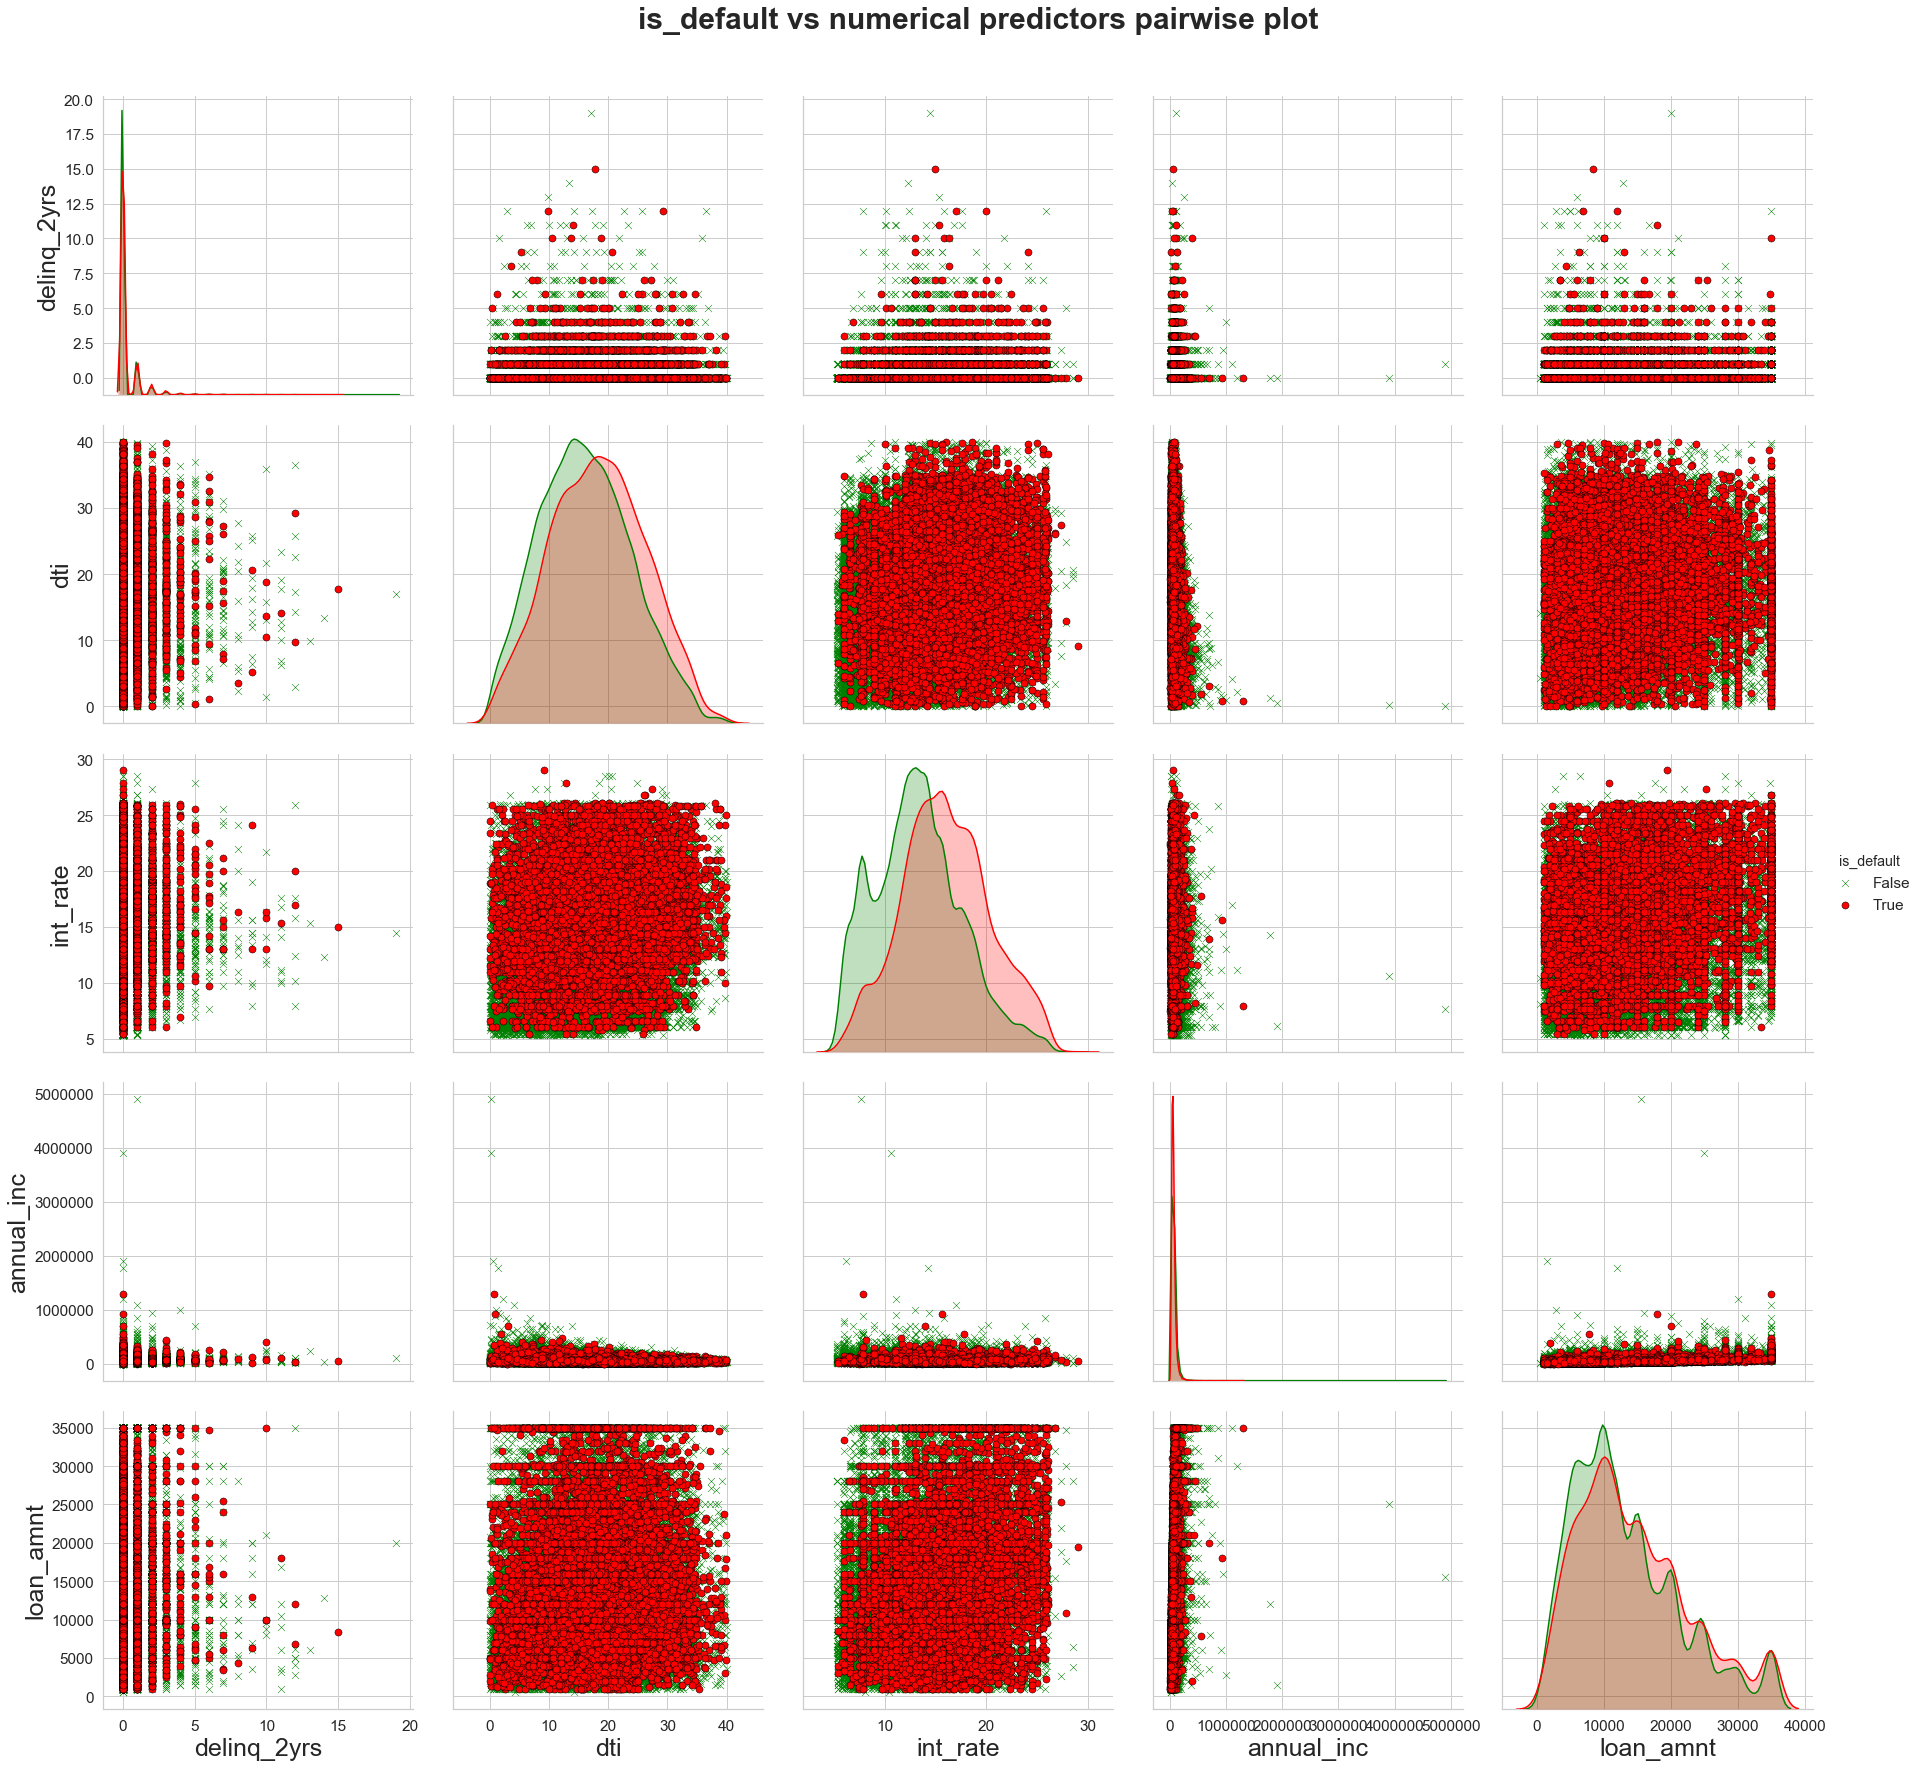

In [236]:
title = 'is_default vs numerical predictors pairwise plot'
plot_pairwise_dependency(
    df.sample(frac=0.2, random_state=32, ),
    columns=['delinq_2yrs', 'dti', 'int_rate', 'annual_inc', 'loan_amnt'],
    hue_column='is_default',
    hue_dict={False: 'green', True: 'red'},
    markers=['x', 'o'], 
    title=title,
    output_path=os.path.join(plots_dir, '_'.join(title.split()))
)

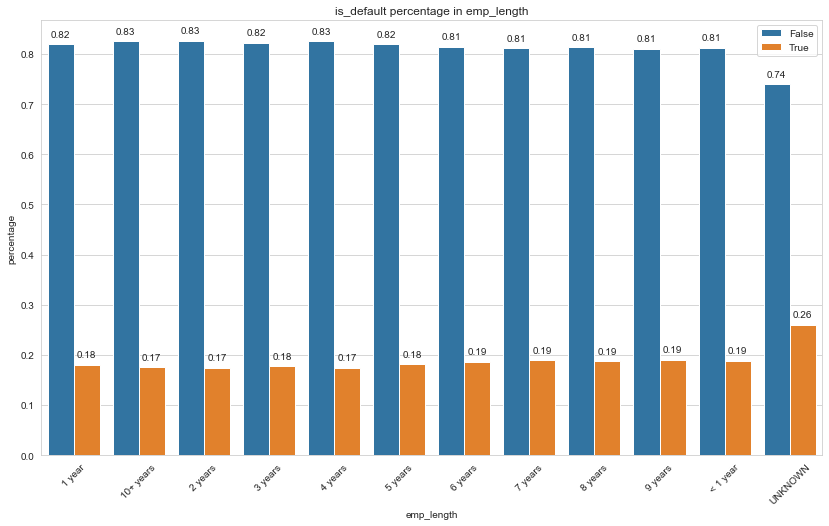

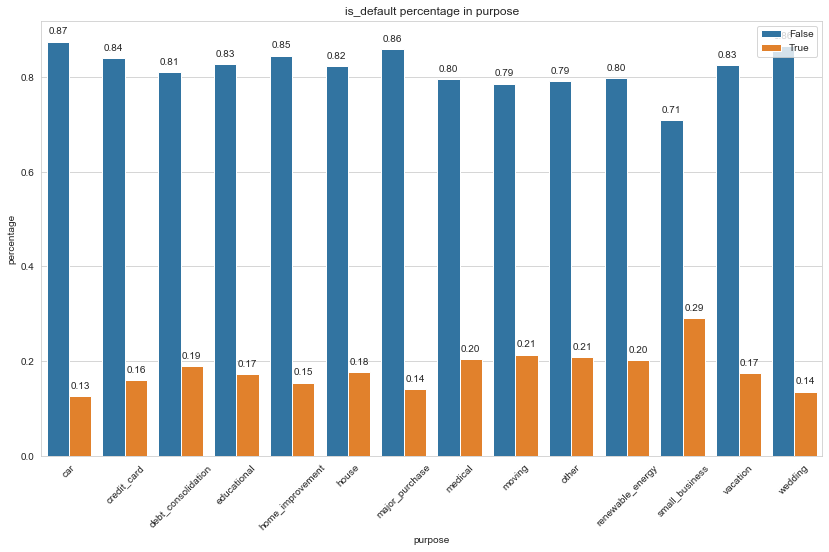

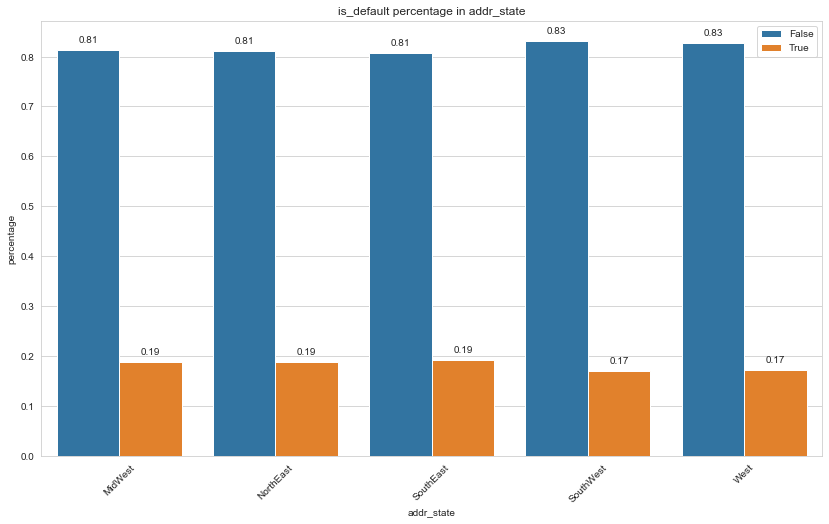

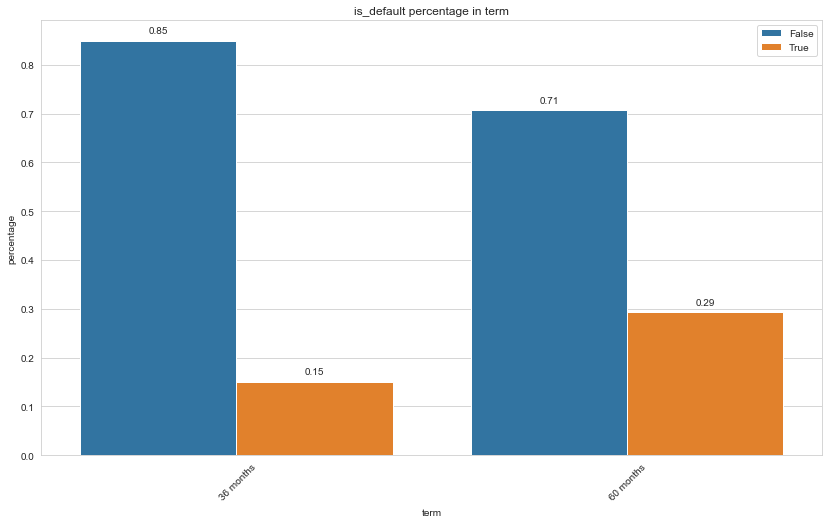

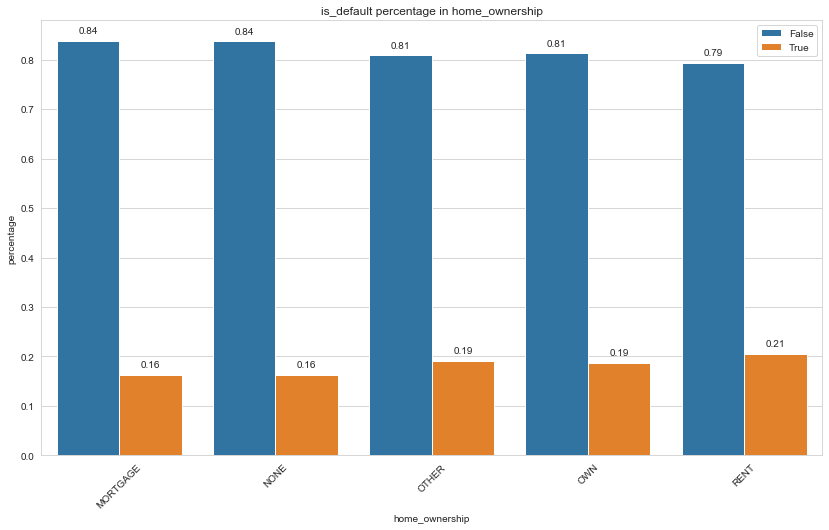

In [586]:
for x in categorical_columns:
    title = f'is_default percentage in {x}'
    plot_normalised_barplot(
        df,
        x, 
        'is_default',
        title=title,
        output_path=os.path.join(plots_dir, '_'.join(title.split()))
    )


## Features preprocessing

In [808]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

In [602]:
target, data = df['is_default'], df.drop(columns=['is_default', 'total_pymnt', 'funded_amnt'])

# one-hot-encoding categorical features
data = pd.get_dummies(data)

In [896]:
# train test split
train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.25, stratify=target, random_state=322)

In [900]:
test_index = test_x.index.copy()
train_index = train_x.index.copy()

In [610]:
scaler = StandardScaler()

train_x = scaler.fit_transform(train_x)
test_x = scaler.transform(test_x)

train_x, test_x = pd.DataFrame(train_x, columns=data.columns), pd.DataFrame(test_x, columns=data.columns)

## Modeling

In [771]:
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression

##### Model 1

In [820]:
params = dict(
    njobs=-1,
    n_estimators=10000,
    learning_rate=0.02,
    num_leaves=32,
    colsample_bytree=0.9497036,
    subsample=0.8715623,
    max_depth=8,
    reg_alpha=0.04,
    reg_lambda=0.073,
    min_split_gain=0.0222415,
    min_child_weight=40,
    silent=-1,
    verbose=-1
)

In [821]:
model_1 = lgb.LGBMClassifier(**params, random_state=30)
model_1.fit(train_x_r, train_y_r)

LGBMClassifier(boosting_type='gbdt', class_weight=None,
               colsample_bytree=0.9497036, importance_type='split',
               learning_rate=0.02, max_depth=8, min_child_samples=20,
               min_child_weight=40, min_split_gain=0.0222415,
               n_estimators=10000, n_jobs=-1, njobs=-1, num_leaves=32,
               objective=None, random_state=30, reg_alpha=0.04,
               reg_lambda=0.073, silent=-1, subsample=0.8715623,
               subsample_for_bin=200000, subsample_freq=0, verbose=-1)

In [822]:
train_pred_1 = model_1.predict_proba(train_x)
test_pred_1 = model_1.predict_proba(test_x)

In [823]:
model_1.score(train_x, train_y)

0.8518899298160951

##### Model 2

In [830]:
model_2 = GaussianNB(var_smoothing=1)
model_2.fit(train_x, train_y)

GaussianNB(priors=None, var_smoothing=1)

In [832]:
model_2.score(train_x, train_y)

0.7973006997408756

In [833]:
train_pred_2 = model_2.predict_proba(train_x)
test_pred_2 = model_2.predict_proba(test_x)

##### Model 3

In [627]:
params = dict(
    loss='deviance',
    learning_rate=0.01,
    n_estimators=2000,
    subsample=0.7,
    criterion='friedman_mse',
    min_samples_split=5,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_depth=6,
    min_impurity_decrease=0.02,
    min_impurity_split=None,
    init=None,
    max_features=0.7,
    verbose=0,
    max_leaf_nodes=None,
    warm_start=False,
    presort='auto',
    validation_fraction=0.1,
    n_iter_no_change=None,
    tol=0.0001,
)

In [628]:
model_3 = GradientBoostingClassifier(**params, random_state=30)
model_3.fit(train_x, train_y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=6,
                           max_features=0.7, max_leaf_nodes=None,
                           min_impurity_decrease=0.02, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=5,
                           min_weight_fraction_leaf=0.0, n_estimators=2000,
                           n_iter_no_change=None, presort='auto',
                           random_state=30, subsample=0.7, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [770]:
model_3.score(train_x, train_y)

0.8306564135919682

In [797]:
train_pred_3 = model_3.predict_proba(train_x)
test_pred_3 = model_3.predict_proba(test_x)

##### Final Model = Average 3 models

In [889]:
train_pred = train_pred_1[:, 1] * 0.3 + train_pred_2[:, 1] * 0.2 + train_pred_3[:, 1] * 0.6
test_pred = test_pred_1[:, 1] * 0.3 + test_pred_2[:, 1] * 0.2 + test_pred_3[:, 1] * 0.6

## Results

In [890]:
from model import calculate_confusion_matrix, plot_confusion_matrix
from sklearn.metrics import roc_curve

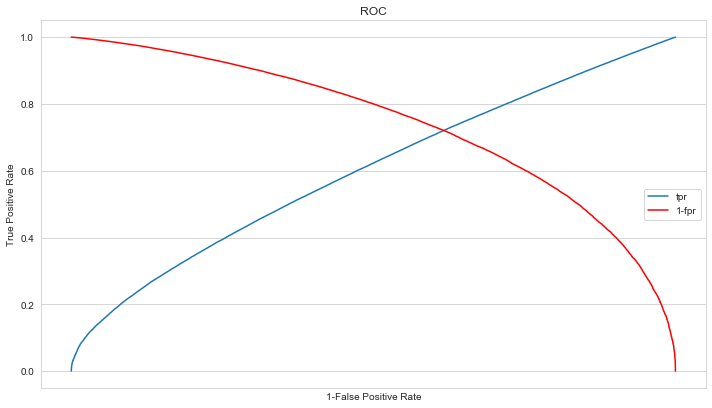

In [891]:
fpr, tpr, thresholds = roc_curve(train_y, train_pred)

# The optimal cut off would be where tpr is high and fpr is low
# tpr - (1-fpr) is zero or near to zero is the optimal cut off point
i = np.arange(len(tpr))  # index for df
roc = pd.DataFrame(
    {
        'fpr': fpr,
        'tpr': tpr,
        '1-fpr': 1 - fpr,
        'tf': tpr - (1 - fpr),
        'thresholds':  thresholds
    }
)
optimal_threshold = roc.iloc[(roc.tf - 0).abs().argsort()[:1]]

# Plot tpr vs 1-fpr
plt.figure(figsize=(10, 6))
plt.plot(roc['tpr'], label='tpr')
plt.plot(roc['1-fpr'], color='red', label='1-fpr')
plt.xlabel('1-False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend()
plt.tight_layout()
plt.xticks([])
plt.show()

In [892]:
threshold = optimal_threshold['thresholds'].iloc[0]
optimal_threshold

,fpr,tpr,1-fpr,tf,thresholds
27742,0.28,0.72,0.72,0.00,0.22


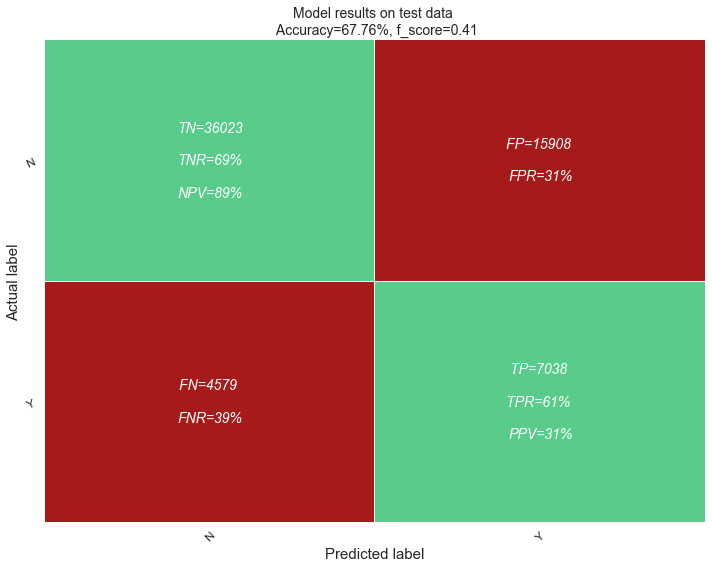

In [893]:
confusion_matrix_metrics = calculate_confusion_matrix(test_y, test_pred > threshold)
plot_confusion_matrix(
    confusion_matrix_metrics, 
    fsize=14,
    title='Model results on test data',
    figsize=(10, 8),
    output_path=os.path.join(plots_dir, 'confusion_matrix_on_test')
)

In [902]:
temp = df.loc[test_index].pivot_table(index=['is_default'], values=['funded_amnt', 'total_pymnt'], aggfunc='sum')
temp.loc['total'] = [temp['funded_amnt'].sum(), temp['total_pymnt'].sum()]
temp['ROI %'] = (temp['total_pymnt'] / temp['funded_amnt'] - 1) * 100

make_stylish_df(temp, axis=0, fmt="{:,.2f}")

,funded_amnt,total_pymnt,ROI %
is_default,,,
False,"691,901,150.00","789,594,612.48",14.12
True,"170,054,000.00","74,558,754.96",-56.16
total,"861,955,150.00","864,153,367.44",0.26


In [903]:
temp = df.loc[test_index].loc[np.invert(test_pred > threshold)].pivot_table(index=['is_default'], values=['funded_amnt', 'total_pymnt'], aggfunc='sum')
temp.loc['total'] = [temp['funded_amnt'].sum(), temp['total_pymnt'].sum()]
temp['ROI %'] = (temp['total_pymnt'] / temp['funded_amnt'] - 1) * 100

make_stylish_df(temp, axis=0, fmt="{:,.2f}")

,funded_amnt,total_pymnt,ROI %
is_default,,,
False,"450,299,500.00","503,814,787.32",11.88
True,"58,372,150.00","27,415,735.70",-53.03
total,"508,671,650.00","531,230,523.02",4.43


## Interpretation

In [470]:
import shap

In [905]:
explainer = shap.TreeExplainer(model_1)
shap_values = explainer.shap_values(train_x, train_y)

/Users/rmelikbe/Desktop/repos/Loan-Default-Prediction/venv/lib/python3.7/site-packages/shap/explainers/tree.py:194: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


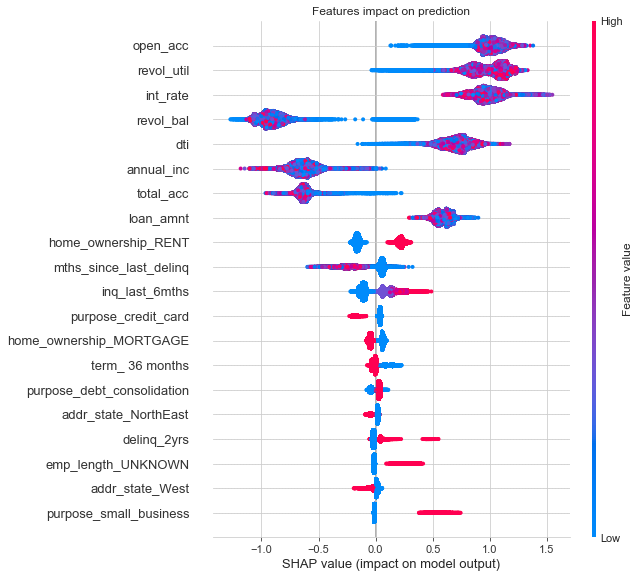

In [912]:
shap.summary_plot(shap_values[1], train_x, show=False)
plt.title('Features impact on prediction')

plt.savefig(os.path.join(plots_dir, 'shap_values'), bbox_inches='tight')
plt.show()